### Import needed modules

In [115]:
import numpy as np
import pandas as pd
import mne
from mne_bids import BIDSPath, read_raw_bids
import pathlib
import matplotlib.pyplot as plt
from itertools import compress
import scipy
import seaborn as sns

In [116]:
# Write own functions
def reorder(raw_initial):
    """
    Input: raw object
    Function: reorders the channels to match the MNE standard
    """
    raw = raw_initial.copy()
    channel_names = raw.ch_names
    channel_names_ordered = []
    for i in range(0, int(len(channel_names)/2)):
        channel_names_ordered.append(channel_names[i])
        channel_names_ordered.append(channel_names[(i + int(len(channel_names)/2))])
    raw_ordered = raw.reorder_channels(channel_names_ordered)
    return raw_ordered

In [117]:
# Export figure?
export = True
sns.set()

### Import test fNIRS data

To find out what the problem is with the timing of the fNIRS recording two demo recordings were made. In both recordings, three blocks with stimuli of 3 sequences were given, similar to the N-back task, but no real fNIRS data was recorded. 

The first recording was performed with a sample frequency determined by the Cortiview software. For the second recording, a sample frequency of 5 Hz was set. 

In [118]:
# Read snirf data
raw = mne.io.read_raw_snirf('test_timings.snirf', optode_frame='unknown', preload=False, verbose=None)

Loading C:\Users\fabia\fNIRS data analysis\Notebooks Master Thesis - Fabian Duren\Timing problem\test_timings.snirf


In [119]:
print('Sample frequency: ' + str(raw.info['sfreq']) + ' Hz')

Sample frequency: 5.58659217877095 Hz


In [120]:
# Read snirf data
raw_5_hz = mne.io.read_raw_snirf('test_5_hz_timings.snirf', optode_frame='unknown', preload=False, verbose=None)

Loading C:\Users\fabia\fNIRS data analysis\Notebooks Master Thesis - Fabian Duren\Timing problem\test_5_hz_timings.snirf


In [121]:
print('Sample frequency: ' + str(raw_5_hz.info['sfreq']) + ' Hz')

Sample frequency: 5.0 Hz


#### Set annotation durations

In [122]:
raw.annotations.set_durations(3)

<Annotations | 28 segments: 1 (10), 2 (10), 3 (8)>

In [123]:
raw_5_hz.annotations.set_durations(3)

<Annotations | 60 segments: 1 (10), 2 (10), 3 (40)>

#### Inspect annotations

Used Annotations descriptions: ['1', '2', '3']


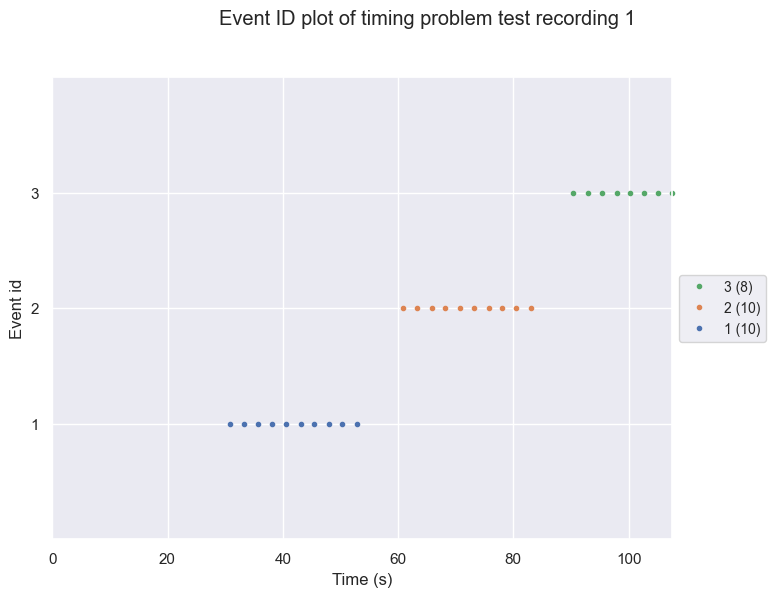

In [124]:
# Look at segments
events, event_dict = mne.events_from_annotations(raw)
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'], show = False)
fig.suptitle('Event ID plot of timing problem test recording 1')
if export:
    fig.savefig('Event_ID_plot_1.png')

In [125]:
for block in ['1', '2', '3']:
    # Get events
    events_block = events[np.where(events[:,2] == event_dict[block])[0]]
    # Find the mean number of samples between events
    samples = np.diff(events_block[:,0])
    mean_samples = np.mean(np.diff(events_block[:,0]))
    # Find mean time between samples
    mean_seconds = mean_samples/raw.info['sfreq']
    times = samples/raw.info['sfreq']
    print('The mean time between two stimuli of ' + block + ' is: ' + str(round(mean_seconds,3)) + ' seconds')
    print('All inter-stimuli durations: ' + str(times))

The mean time between two stimuli of 1 is: 2.446 seconds
All inter-stimuli durations: [2.506 2.327 2.506 2.506 2.506 2.327 2.506 2.327 2.506]
The mean time between two stimuli of 2 is: 2.466 seconds
All inter-stimuli durations: [2.506 2.506 2.327 2.506 2.506 2.506 2.327 2.506 2.506]
The mean time between two stimuli of 3 is: 2.455 seconds
All inter-stimuli durations: [2.506 2.506 2.506 2.327 2.506 2.327 2.506]


Used Annotations descriptions: ['1', '2', '3']


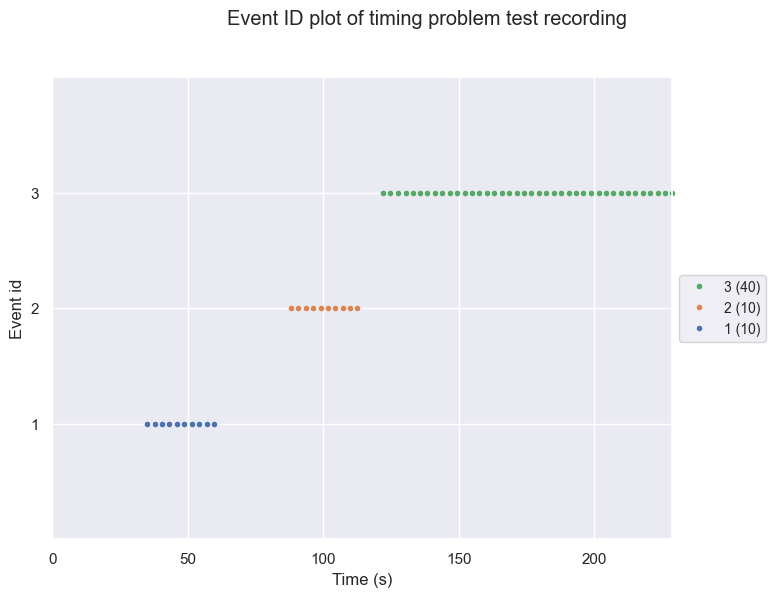

In [126]:
# Look at segments
events_5_hz, event_dict_5_hz = mne.events_from_annotations(raw_5_hz)
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
fig = mne.viz.plot_events(events_5_hz, event_id=event_dict_5_hz, sfreq=raw_5_hz.info['sfreq'], show = False)
fig.suptitle('Event ID plot of timing problem test recording')
if export:
    fig.savefig('Event_ID_plot_2.png')

In [127]:
for block in ['1', '2', '3']:
    # Get events
    events_block = events_5_hz[np.where(events_5_hz[:,2] == event_dict_5_hz[block])[0]]
    # Find the mean number of samples between events
    samples = np.diff(events_block[:,0])
    mean_samples = np.mean(np.diff(events_block[:,0]))
    # Find mean time between samples
    mean_seconds = mean_samples/raw_5_hz.info['sfreq']
    times = samples/raw_5_hz.info['sfreq']
    print('The mean time between two stimuli of ' + block + ' is: ' + str(round(mean_seconds,3)) + ' seconds')
    print('All inter-stimuli durations: ' + str(times))

The mean time between two stimuli of 1 is: 2.756 seconds
All inter-stimuli durations: [2.8 2.8 2.6 2.8 2.8 2.8 2.6 2.8 2.8]
The mean time between two stimuli of 2 is: 2.733 seconds
All inter-stimuli durations: [2.8 2.8 2.6 2.8 2.8 2.6 2.8 2.8 2.6]
The mean time between two stimuli of 3 is: 2.733 seconds
All inter-stimuli durations: [2.6 2.8 2.8 2.6 2.8 2.6 2.8 2.8 2.6 2.8 2.8 2.8 2.6 2.8 2.8 2.8 2.6 2.8
 2.8 2.6 2.8 2.6 2.8 2.8 2.8 2.6 2.8 2.8 2.8 2.6 2.8 2.8 2.6 2.8 2.8 2.6
 2.8 2.8 2.6]


---
> *Remark:*
- From this observation it becomes clear that according to the timestamps in the fNIRS recording, the time betwen stimuli within each blocks was around 2.5 s and 2.75 s for the first and second recording respectively.
- Due to the fixed sampling frequency, these durations are also always a multiple of the inverse of the sample frequency (quite logical)
- But even when taking a sample rate that is able to exactly time 3 seconds (5 Hz), the correct duration is not observed
- However, according to the timelogs of the stimulus presentation software PsychoPy, the duration between two stimuli needs to be 3 s
---

#### Inspect visually

In [128]:
# Plot raw data
%matplotlib qt
raw.plot(duration = 10, show_scrollbars = True, clipping = None);

Channels marked as bad:
none


In [129]:
# Plot raw data
%matplotlib qt
raw_5_hz.plot(duration = 10, show_scrollbars = True, clipping = None);

Channels marked as bad:
none


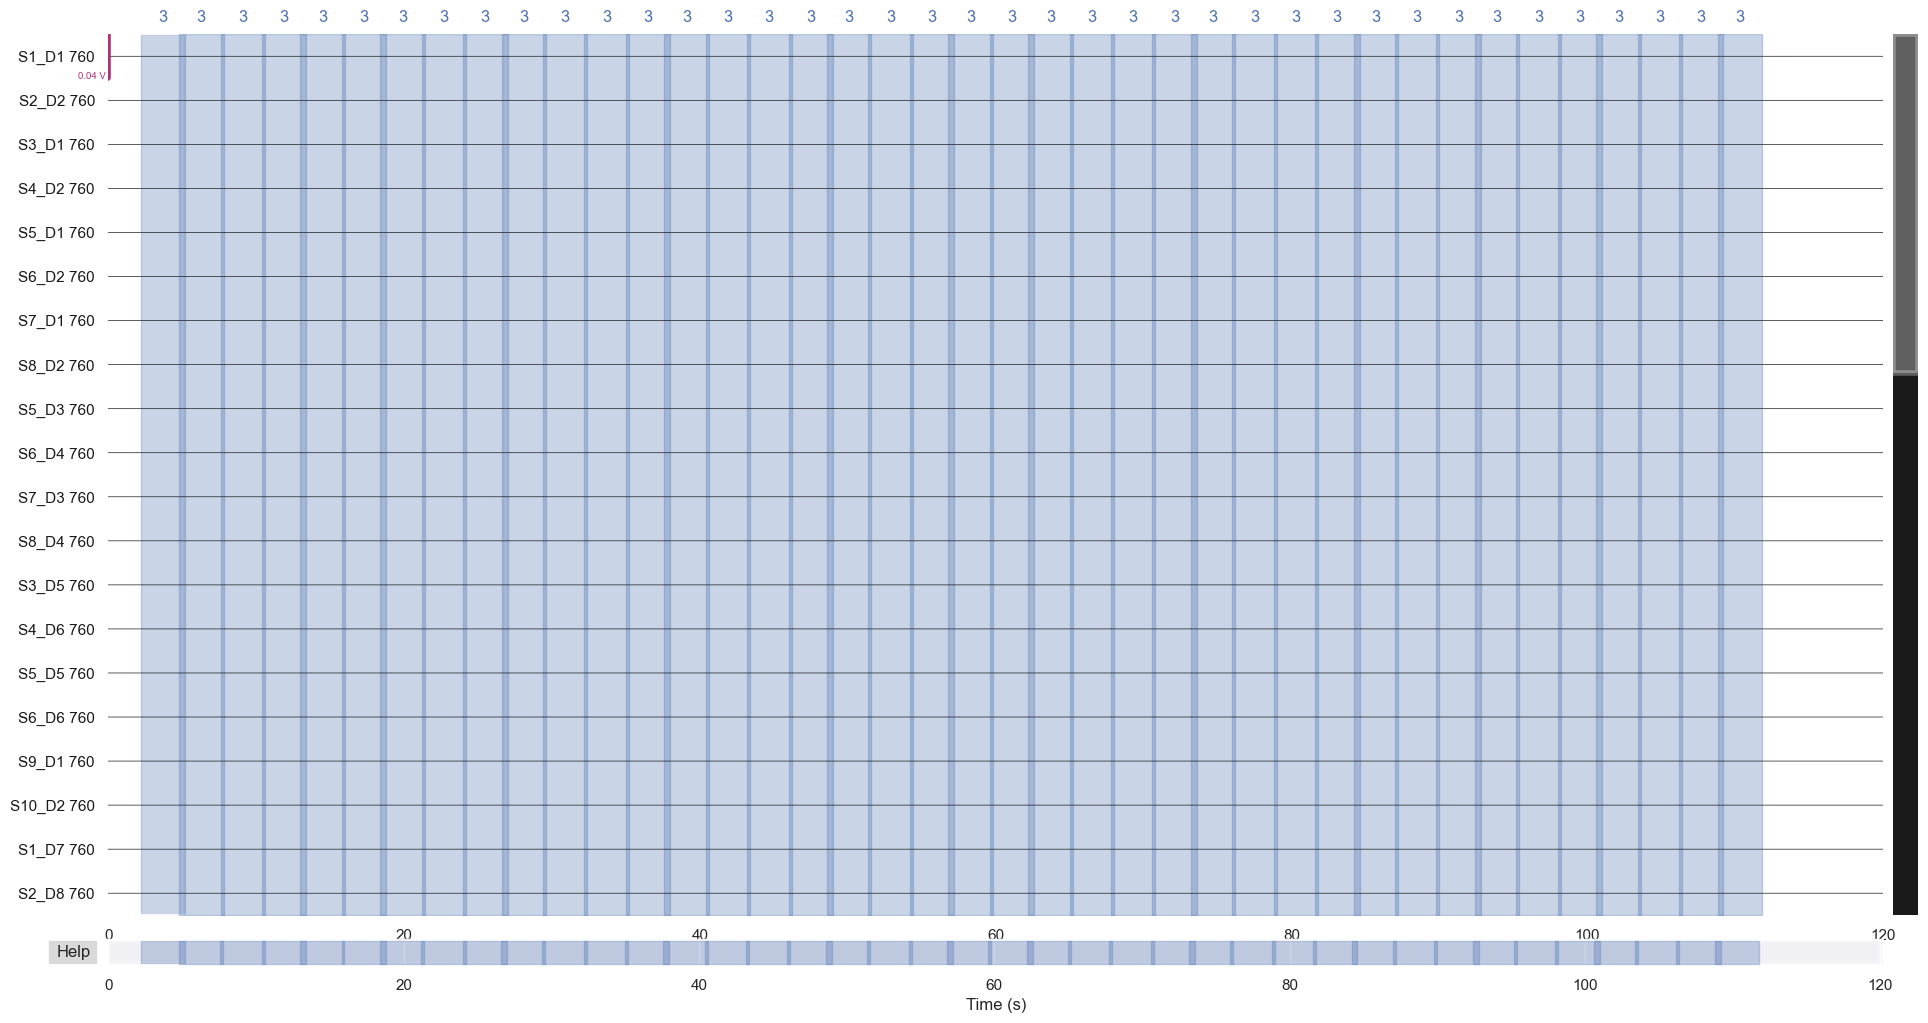

In [130]:
%matplotlib inline
fig = raw_5_hz.copy().crop(120,240).plot(duration = 120, show_scrollbars = True, clipping = None)
if export:
    fig.savefig('120_s_overlap.png')

---
> *Remark:*
- Indeed, in the recording the stimuli overlap (as we manually set the duration of each stimulus to 3 seconds)
- Not only do they overlap, the whole recording seems to be sped up in time
---



To test this hypothesis, we manually recorded the duration of the final block of the 5 Hz recording. Theoretically, 40 stimuli presented over 3 seconds each should result in a total duration of 2 minutes. According to the PsychoPy data log, this duration is accurate. However, to ensure that the issue was not due to the PsychoPy software (or E-Prime software, as the problem was observed there as well), we timed the duration manually. Indeed, the segmented block took exactly 120 seconds to complete.

In [131]:
# Time between first and last stimuli of thrid block of 5 Hz recording (expected to be 40 * 3 s - 3s = 117 s)
events_block = events_5_hz[np.where(events_5_hz[:,2] == event_dict_5_hz['3'])[0]]
samples = events_block[-1,0] - events_block[0,0]
print('Duration: ' + str(samples/raw_5_hz.info['sfreq']) + ' s')
print('Difference with expected duration: ' + str(117-samples/raw_5_hz.info['sfreq'])) 

Duration: 106.6 s
Difference with expected duration: 10.400000000000006


In [132]:
# Recording is 'sped up' by factor
3/2.733

1.097694840834248

### Compare N-back recording with and without timestamp issue

In [133]:
raws = []
data_dir = pathlib.Path("C:/Users/fabia/fNIRS data analysis/N-back analysis/N_back data_BIDS")
bids_root = data_dir.with_name(data_dir.name)
for sub in range(1, 5):  # Loop from first to fourth subject
    # Create path to file based on experiment info
    bids_path = BIDSPath(subject="%02d" % sub, task="Nback", datatype="nirs",
                         root=bids_root, suffix="nirs",
                         extension=".snirf")
    raws.append(read_raw_bids(bids_path=bids_path, verbose=False))
raws

[<RawSNIRF | sub-01_task-Nback_nirs.snirf, 32 x 20463 (2046.2 s), ~36 kB, data not loaded>,
 <RawSNIRF | sub-02_task-Nback_nirs.snirf, 32 x 40258 (4549.0 s), ~36 kB, data not loaded>,
 <RawSNIRF | sub-03_task-Nback_nirs.snirf, 32 x 20339 (2277.9 s), ~36 kB, data not loaded>,
 <RawSNIRF | sub-04_task-Nback_nirs.snirf, 32 x 21552 (2650.8 s), ~36 kB, data not loaded>]

In [134]:
raw_intensities = []
# Reorder channels (Due to non-uniformity between mne_nirs and .snirf data)
for sub in range(4):
    raw_intensities.append(reorder(raws[sub]))

In [135]:
# Look at characteristics
sfreqs = []
lowpass = []
for sub in range(4):
    print('Participant ' + str(sub+1) + ' :')
    print(raw_intensities[sub].info)
    sfreqs.append(raw_intensities[sub].info['sfreq'])
    lowpass.append(raw_intensities[sub].info['lowpass'])
print('Sample frequencies (Hz): ' + str(sfreqs))
print('Max bandwidth (Hz): ' + str(lowpass))

Participant 1 :
<Info | 12 non-empty values
 bads: []
 ch_names: S1_D1 760, S1_D1 850, S2_D2 760, S2_D2 850, S3_D1 760, S3_D1 ...
 chs: 32 fNIRS (CW amplitude)
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 18 items (18 EEG)
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 5.0 Hz
 meas_date: 2024-04-29 13:36:30 UTC
 nchan: 32
 projs: []
 sfreq: 10.0 Hz
 subject_info: 3 items (dict)
>
Participant 2 :
<Info | 12 non-empty values
 bads: []
 ch_names: S1_D1 760, S1_D1 850, S2_D2 760, S2_D2 850, S3_D1 760, S3_D1 ...
 chs: 32 fNIRS (CW amplitude)
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 18 items (18 EEG)
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 4.4 Hz
 meas_date: 2024-04-12 16:28:04 UTC
 nchan: 32
 projs: []
 sfreq: 8.8 Hz
 subject_info: 3 items (dict)
>
Participant 3 :
<Info | 12 non-empty values
 bads: []
 

Used Annotations descriptions: ['0Back', '2Back_block1', '2Back_block2', '2Back_block3', 'Baseline', 'Practice/0Back', 'Practice/2Back']
Used Annotations descriptions: ['0Back', '2Back_block1', '2Back_block2', '2Back_block3', 'Baseline', 'Practice/0Back', 'Practice/2Back']
Used Annotations descriptions: ['0Back', '2Back_block1', '2Back_block2', '2Back_block3', 'Baseline', 'Practice/0Back', 'Practice/2Back']
Used Annotations descriptions: ['0Back', '2Back_block1', '2Back_block2', '2Back_block3', 'Baseline', 'Practice/0Back', 'Practice/2Back']


C:\Users\fabia\AppData\Local\Temp\ipykernel_17144\3868527857.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


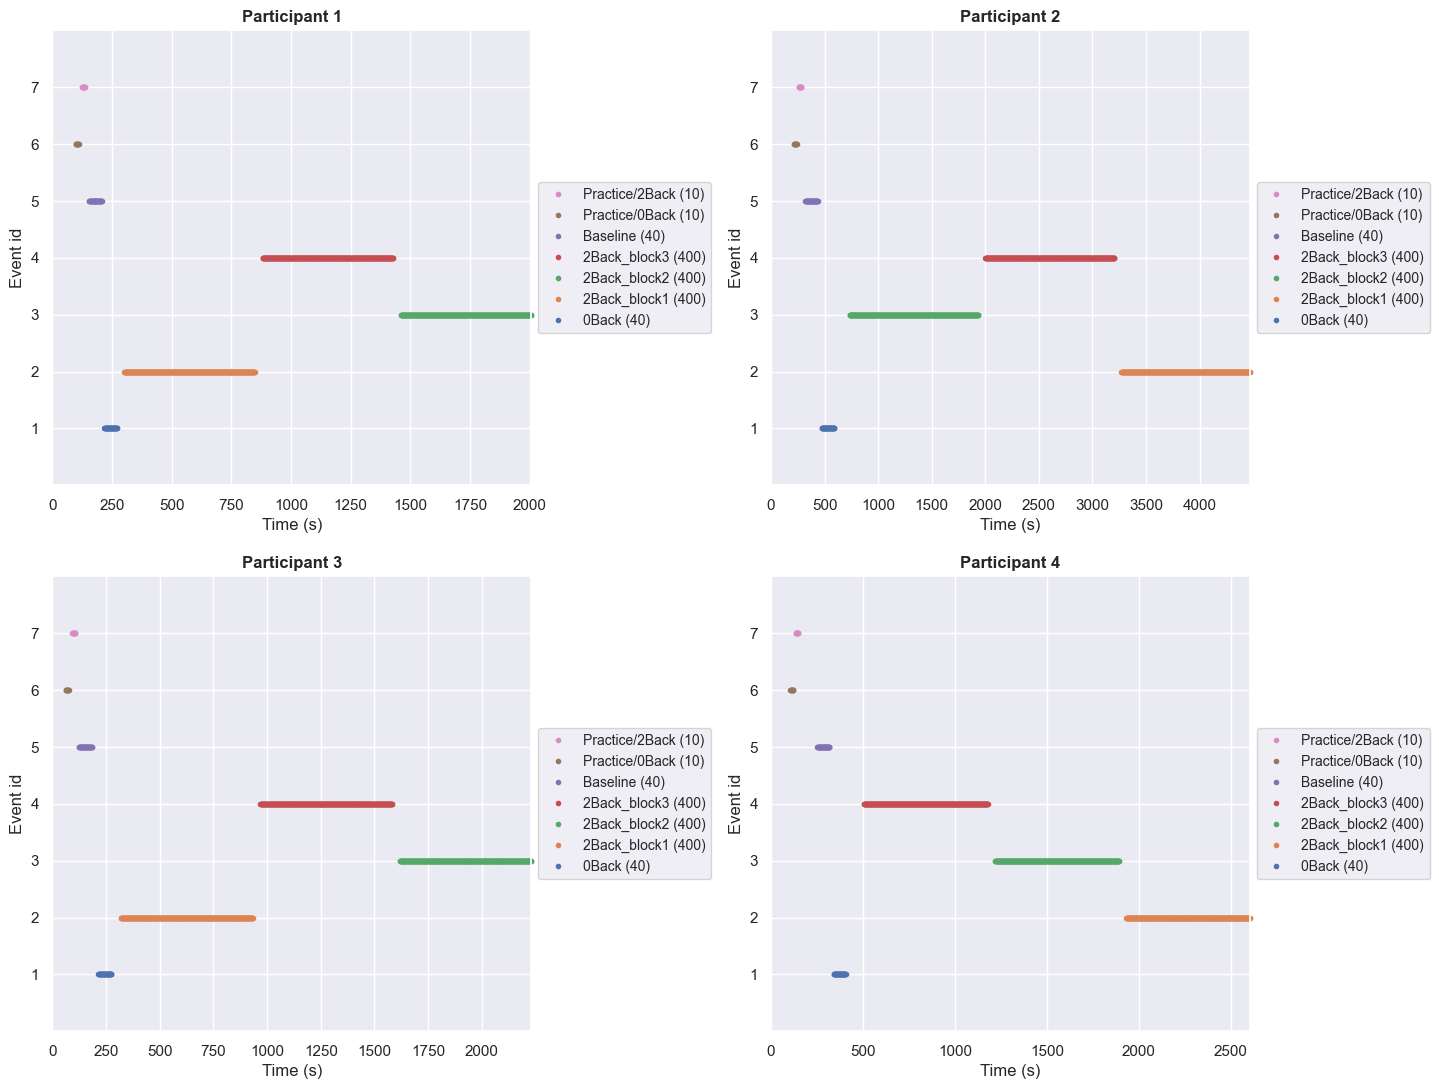

In [136]:
# Look at segments
events = []
event_dicts = []
for sub in range(4):
    event, event_dict = mne.events_from_annotations(raw_intensities[sub])
    events.append(event)
    event_dicts.append(event_dict)
%matplotlib inline
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(17, 13))

mne.viz.plot_events(events[0], event_id=event_dicts[0], sfreq=raw_intensities[0].info['sfreq'], axes=axes[0,0], show = False)
mne.viz.plot_events(events[1], event_id=event_dicts[1], sfreq=raw_intensities[1].info['sfreq'], axes=axes[0,1], show = False)
mne.viz.plot_events(events[2], event_id=event_dicts[2], sfreq=raw_intensities[2].info['sfreq'], axes=axes[1,0], show = False)
mne.viz.plot_events(events[3], event_id=event_dicts[3], sfreq=raw_intensities[3].info['sfreq'], axes=axes[1,1], show = False)
axes[0,0].set_title('Participant 1', fontweight="bold")
axes[0,1].set_title('Participant 2', fontweight="bold")
axes[1,0].set_title('Participant 3', fontweight="bold")
axes[1,1].set_title('Participant 4', fontweight="bold")

if export:
    fig.savefig('events_Nback.png')

fig.show()

In [137]:
# Visualize in a dataframe
data = []
for sub in range(4):
    sub_data = [sub + 1] 
    for block in ['2Back_block1', '2Back_block2', '2Back_block3']:
        events_block = events[sub][np.where(events[sub][:, 2] == event_dict[block])[0]]
        mean_samples = np.mean(np.diff(events_block[:, 0]))
        mean_seconds = mean_samples / raw_intensities[sub].info['sfreq']
        sub_data.append(round(mean_seconds, 3))
    data.append(sub_data)

# Create a DataFrame
columns = ['Subject', 'block 1', 'block 2', 'block 3']
df = pd.DataFrame(data, columns=columns).round(3)
df.set_index('Subject', inplace=True)
df.style.background_gradient(cmap='Blues')

,block 1,block 2,block 3
Subject,,,
1,1.370000,1.371000,1.371000
2,3.010000,3.010000,3.012000
3,1.535000,1.536000,1.536000
4,1.687000,1.687000,1.687000


In [138]:
60*20*3 + 60*3

3780

---
> *Remark:*
- From the N-back experiment we imported the fNIRS data of the subjects.
- For the first subject, a problem with the timestamps is observed; (1) Duration of recording is much shorter than expected, as the 2-back task alone already should consist of 60 s * 20 minutes * 3 blocks + 60 s * 1 minute * 3 MF surveys = 3780 s, while the recording softawre states that the total length of the recording is 2000 s. (2) Duration between two stimuli of the N-back is on average 1.37 s instead of 3 s.
- The second subject does not have the timestamp issue.
- For subject 3 and 4 similar conclusions as for the first subject can be made.
---


#### Visualize segment of fNIRS recordings

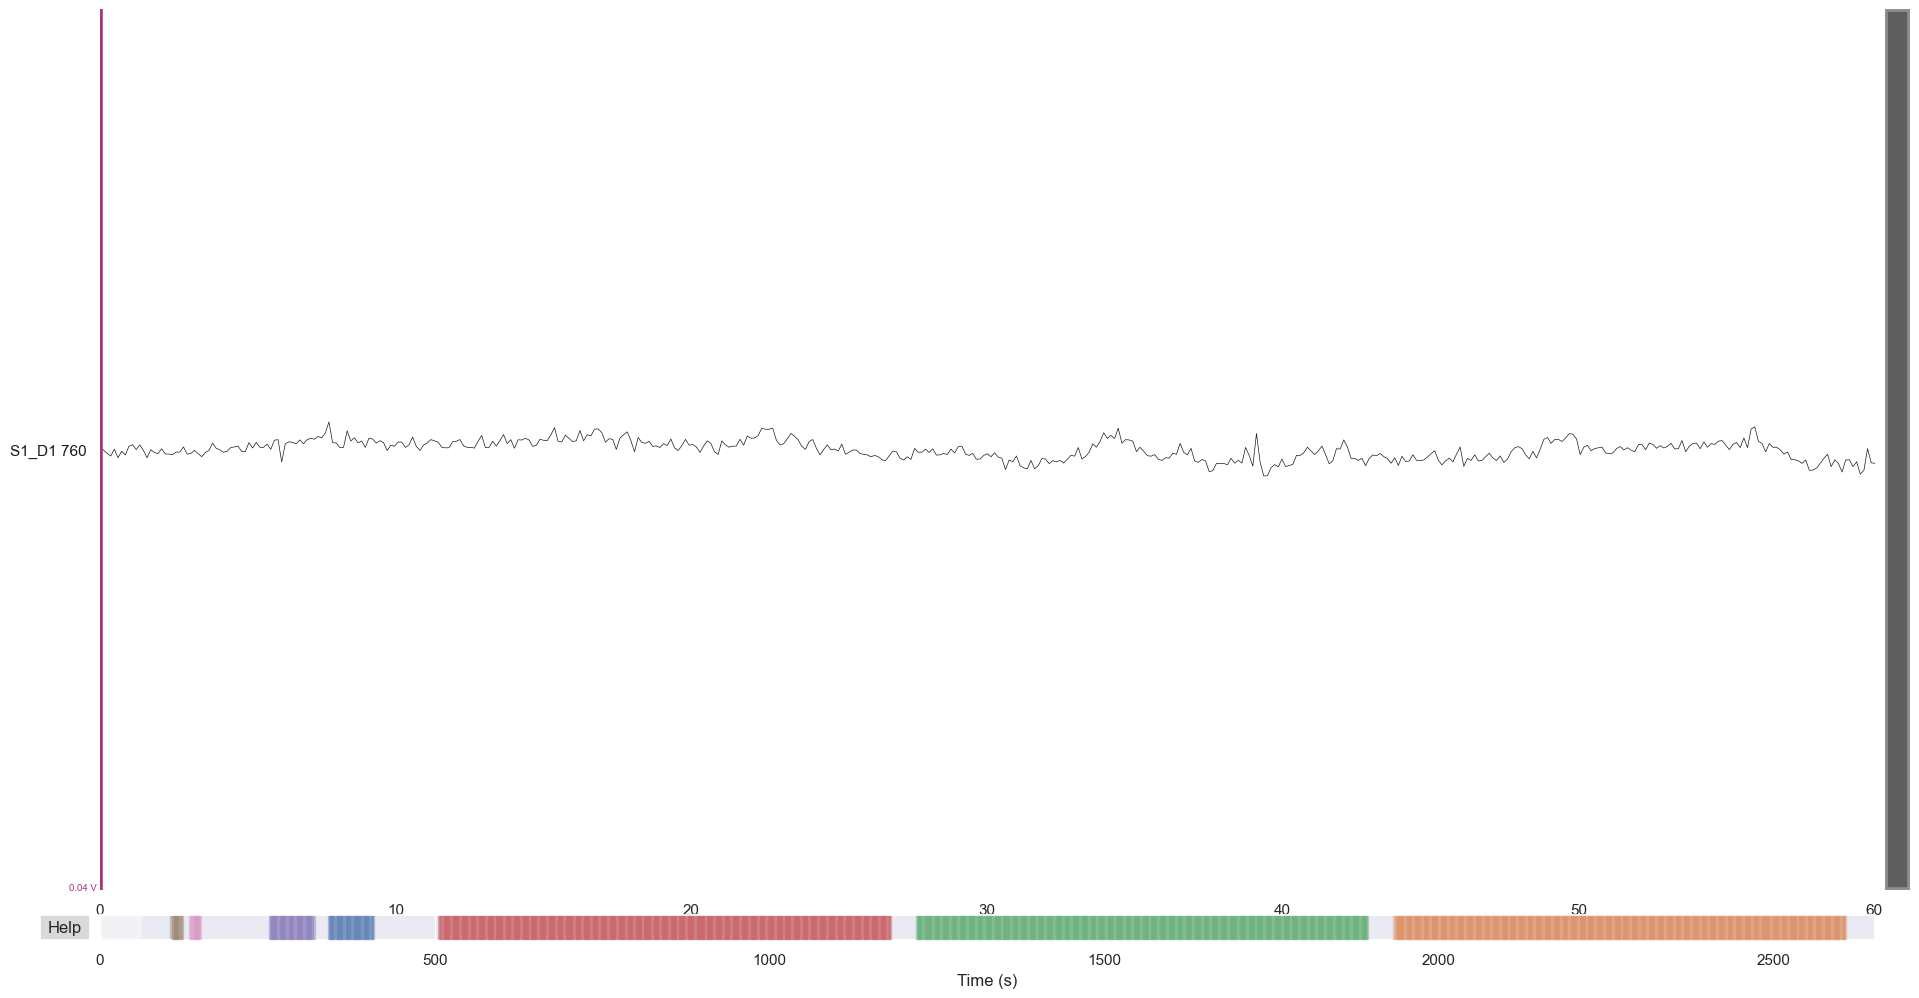

Channels marked as bad:
none


In [139]:
# Subject 4 is too noisy
%matplotlib qt
raw_intensities[3].copy().pick(0).plot(duration = 60)

In [140]:
# Select first channel
chan = 0
for sub in range(3):
    print(raw_intensities[sub].ch_names[chan])

# Select 60 s time segment within first 2-back block
tmin_sub_1, tmax_sub_1  = 615, 675
tmin_sub_2, tmax_sub_2  = 1001, 1061
tmin_sub_3, tmax_sub_3  = 501, 561

S1_D1 760
S1_D1 760
S1_D1 760


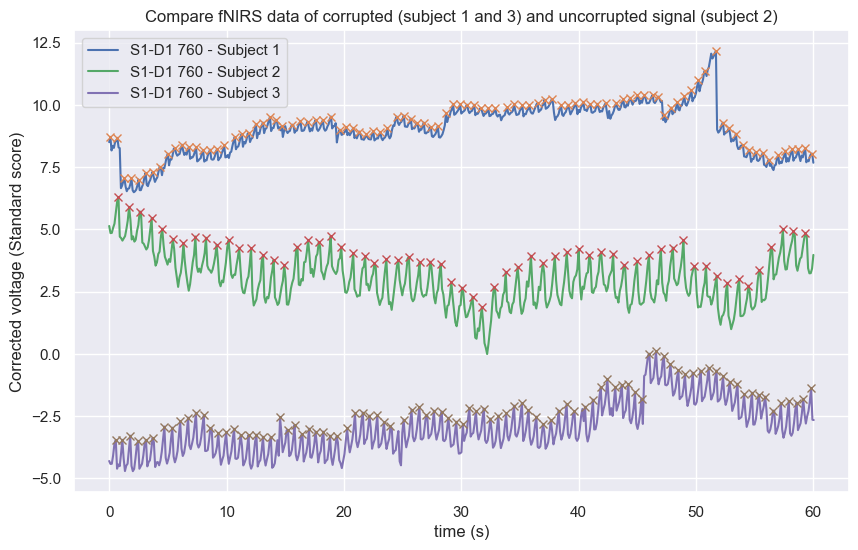

In [141]:
%matplotlib inline
channel_sub_1 = raw_intensities[0].copy().pick(picks = chan).crop(tmin_sub_1, tmax_sub_1).get_data()[0]
channel_sub_2 = raw_intensities[1].copy().pick(picks = chan).crop(tmin_sub_2, tmax_sub_2).get_data()[0]
channel_sub_3 = raw_intensities[2].copy().pick(picks = chan).crop(tmin_sub_3, tmax_sub_3).get_data()[0]
# channel_sub_4 = raw_intensities[3].copy().pick(picks = chan).crop(tmin_sub_4, tmax_sub_4).get_data()[0]
# For better visualization
corrected_channel_sub_1 = (channel_sub_1 - np.mean(channel_sub_1))/np.std(channel_sub_1) + 9
corrected_channel_sub_2 = (channel_sub_2 - np.mean(channel_sub_2))/np.std(channel_sub_2) + 3
corrected_channel_sub_3 = (channel_sub_3 - np.mean(channel_sub_3))/np.std(channel_sub_3) - 3
#corrected_channel_sub_4 = (channel_sub_4 - np.mean(channel_sub_4))/np.std(channel_sub_4) - 9

# Find HR peaks
peaks_1 = scipy.signal.find_peaks(corrected_channel_sub_1, distance=5)[0]
peaks_2 = scipy.signal.find_peaks(corrected_channel_sub_2, distance=5)[0]
peaks_3 = scipy.signal.find_peaks(corrected_channel_sub_3, distance=5)[0]
#peaks_4 = scipy.signal.find_peaks(corrected_channel_sub_4, distance=5)[0]

t_sub_1 = np.arange(len(channel_sub_1))/raw_intensities[0].info['sfreq']
t_sub_2 = np.arange(len(channel_sub_2))/raw_intensities[1].info['sfreq']
t_sub_3 = np.arange(len(channel_sub_3))/raw_intensities[2].info['sfreq']
#t_sub_4 = np.arange(len(channel_sub_4))/raw_intensities[3].info['sfreq']

plt.plot(t_sub_1, corrected_channel_sub_1, label = 'S1-D1 760 - Subject 1') 
plt.plot(peaks_1/raw_intensities[0].info['sfreq'], corrected_channel_sub_1[peaks_1], 'x')
plt.plot(t_sub_2, corrected_channel_sub_2, label = 'S1-D1 760 - Subject 2')
plt.plot(peaks_2/raw_intensities[1].info['sfreq'], corrected_channel_sub_2[peaks_2], 'x')
plt.plot(t_sub_3, corrected_channel_sub_3, label = 'S1-D1 760 - Subject 3')
plt.plot(peaks_3/raw_intensities[2].info['sfreq'], corrected_channel_sub_3[peaks_3], 'x')
# plt.plot(t_sub_4, corrected_channel_sub_4, label = 'S1-D1 760 - Subject 4')
# plt.plot(peaks_4/raw_intensities[3].info['sfreq'], corrected_channel_sub_4[peaks_4], 'x')
plt.xlabel('time (s)')
plt.ylabel('Corrected voltage (Standard score)')
plt.title('Compare fNIRS data of corrupted (subject 1 and 3) and uncorrupted signal (subject 2)')
plt.legend()
if export:
    plt.savefig('timing_problem.png')

In [143]:
# Get HR
HR_sub_1 = len(peaks_1)
print('Heart rate of first subject: ' + str(HR_sub_1))
HR_sub_2 = len(peaks_2)
print('Heart rate of second subject: ' + str(HR_sub_2))
HR_sub_3 = len(peaks_3)
print('Heart rate of third subject: ' + str(HR_sub_3))

Heart rate of first subject: 97
Heart rate of second subject: 62
Heart rate of third subject: 93
